# latent space walks for an N-dimensional normal distribution

In [1]:
import os
import sys
import pickle

import numpy as np
import numba
import multiprocessing
import matplotlib.pyplot as plt

%matplotlib inline

## optimized mc sampling

In [ ]:
# this code looks a little different from the standard mc algorithm,
# mostly because i'm working in log-space
# the cryptic `-np.sum(d*(0.5*d + x))` is from simplifying log( e^(x+d)^2/2 /e^(x^2)/2 )

In [2]:
@numba.jit(nopython=True)
def mc_sample_unit_normal(seed, dim=128, L=1000, sigma=0.1, stride=10):

    np.random.seed(seed)
    N = int(L/stride)
    traj = np.zeros(shape=(N,dim), dtype=np.double)

    for i in range(1,N):

        # generate batches of rands for effiency's sake
        ds = sigma*np.random.randn(stride,dim)
        rs = np.log(np.random.rand(stride))

        # move around but don't record for stride steps
        x = traj[i-1]
        for j in range(stride):
            d = ds[j]
            r = rs[j]
            if r < np.minimum(0.0, -np.sum(d*(0.5*d + x))):
                x += d

        traj[i] = x

    return traj

In [3]:
out = mc_sample_unit_normal(3, dim=128, L=1000000, sigma=0.01, stride=100)

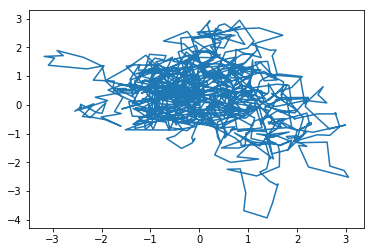

In [4]:
plt.plot(out[:,99],out[:,100]);

## parallel version using multiprocessing.Pool

In [6]:
# specialize function for parallel mapping htat inlines the optional
def mc_sample_unit_normal_forpar(seed):
    
    dim=128
    L=1000000
    sigma=0.01
    stride=100
    
    traj = mc_sample_unit_normal(seed, dim=dim, L=L, sigma=sigma, stride=stride)
    pickle.dump(traj, open( os.path.join('walks',"walk_" + str(seed) + ".pkl"), "wb" ) )

# define the parallel map job
def parallel_trajs(seeds, threads=2):
    pool = multiprocessing.Pool(threads)
    results = pool.map(mc_sample_unit_normal_forpar, seeds)
    pool.close()
    pool.join()
    return results

In [7]:
# run inner function once to jit compile and inspect results
mc_sample_unit_normal_forpar(12321)

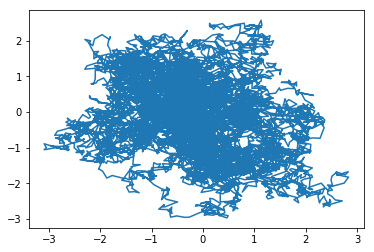

In [8]:
out = pickle.load( open( os.path.join('walks',"walk_" + str(12321) + ".pkl"), "rb" ) )
plt.plot(out[:,99],out[:,100]);

In [18]:
## Run in parallel

In [11]:
# run in parallel
N_cpus = max(multiprocessing.cpu_count()-2,1) # leave one free
jobs = range(16000)
out_trajs_par = parallel_trajs(jobs, threads=N_cpus)